In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from ete3 import Tree
import os
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import sys
sys.path.append("..")
from services.pbs_service import PBSService
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import math
import pickle

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, use_memory_fs=False)

from datetime import date
from pathlib import Path

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [29]:
resolve_tree = False
resolve_ccdb = False # ccdb taxonome name resolution is set to false
tree_name = "ALLMB" # "ALLMB" or "ALLOTB"
use_added_ccdb_species = True
include_missing = True
min_species_in_group = 5
with_model_weighing = True

group_by = "genus" # "genus" / "family", / "time"
time_point = 5

tree_path =  f"../trees/resolved_{tree_name}_name_resolution_on_none_with_added_ccdb_{'and_wo_counts_' if include_missing else ''}names.nwk"
ccdb_path = f"../ccdb/all_data_171122.csv"
tax_classification_path = "../trees/resolved_ALLMB_name_resolution_on_none_with_added_ccdb_and_wo_counts_names_classification_data.csv"

partition_roots_path = f"../trees/time_points_to_internal_nodes_to_partition_by{'_with_missing_data' if include_missing else ''}.pkl" if group_by == "time" else f"../trees/optimal_{tree_name}_roots_for_{group_by}_partition.csv"
if group_by == "genus" and include_missing:
    partition_roots_path = "../trees/optimal_by_wo_missing_ALLMB_roots_for_genus_partition.csv"


pipeline_script_path = "/groups/itay_mayrose/halabikeren/tmp/ploidb/exec_ploidb_pipeline.py"
groupby_str = group_by + (f"_{time_point}" if group_by == "time" else "")
chromevol_input_dir = f"../chromevol/with{'' if with_model_weighing else 'out'}_model_weighting/by_{groupby_str}_on_{'resolved' if resolve_tree else 'unresolved'}_{tree_name}_and_{'resolved' if resolve_ccdb else 'unresolved'}_ccdb{'_include_all_possible_missing' if include_missing else ''}/"
job_commands_path = f"{chromevol_input_dir}/stats.csv"

# parse ccdb and the complete tree

In [3]:
os.makedirs(chromevol_input_dir, exist_ok=True)
chromevol_input_dir

'/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb_include_all_possible_missing/'

In [4]:
tax_classification_df = pd.read_csv(tax_classification_path)
    
tree = Tree(tree_path, format=1)
for leaf in tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

leaf_names = tree.get_leaf_names()
print(f"# leaves = {len(leaf_names):,}")

ccdb = pd.read_csv(ccdb_path)
ccdb.mapped_name = ccdb.mapped_name.str.lower()
print(f"# ccdb mapped names = {len(ccdb.mapped_name.unique()):,}")
ccdb = ccdb.loc[ccdb.mapped_name.isin(tree.get_leaf_names())]

if not include_missing:
    intersection_ccdb = ccdb.loc[ccdb.mapped_name.isin(leaf_names)].mapped_name.unique().tolist()
    print(f"# ccdb records = {len(intersection_ccdb):,}")
    tree.prune(intersection_ccdb, preserve_branch_length=True)

ccdb = ccdb.groupby("mapped_name")["parsed_n"].apply(lambda n: sorted(n.dropna().tolist())[(len(n)//2-(1 if len(n)%2 == 0 else 0))]).reset_index().rename(columns={"parsed_n": "parsed_n_median"})
ccdb.mapped_name = ccdb.mapped_name.str.lower()
ccdb["genus"] = np.nan
ccdb["family"] = np.nan
ccdb.set_index("mapped_name", inplace=True)
ccdb.genus.fillna(value=tax_classification_df.set_index("taxon")["genus"].to_dict(), inplace=True)
ccdb.family.fillna(value=tax_classification_df.set_index("taxon")["family"].to_dict(), inplace=True)
ccdb.reset_index(inplace=True)

genus_to_size = ccdb[["genus", "mapped_name"]].groupby("genus").count()["mapped_name"].to_dict()
ccdb["genus_size"] = ccdb.genus.apply(lambda g: genus_to_size.get(g, np.nan))
print(f"# tree leaves = {len(tree.get_leaf_names()):,}")
print(f"# mapped ccdb names = {len(ccdb.mapped_name.unique()):,}")
print(f"# tree leaves with ccdb data = {len(ccdb.loc[ccdb.mapped_name.isin(tree.get_leaf_names())].mapped_name.unique()):,}")
print(f"# mapped ccdb names from genera of size >= 5  = {len(ccdb.loc[ccdb.genus_size >= 5].mapped_name.unique()):,}")
print(f"# mapped ccdb names from genera of size < 5  = {len(ccdb.loc[ccdb.genus_size < 5].mapped_name.unique()):,}")

# leaves = 276,195
# ccdb mapped names = 78,139
# tree leaves = 276,195
# mapped ccdb names = 70,186
# tree leaves with ccdb data = 70,186
# mapped ccdb names from genera of size >= 5  = 62,051
# mapped ccdb names from genera of size < 5  = 8,135


In [5]:
ccdb.loc[ccdb.mapped_name == "hosta sieboldii", "parsed_n_median"] = 30

In [6]:
%%time

print(f"extracting selected MRCA from {partition_roots_path}")
def get_leaves(name: str) -> int:
    try:
        root = tree.search_nodes(name=name)[0]
        root_leaves = root.get_leaf_names()
        return root_leaves
    except Exception as e:
        print(f"could not find members under {name} due to error {e}") 
        return []

if group_by == "time":
    ccdb["time_root_name"] = np.nan
    with open(partition_roots_path, "rb") as infile:
        partition_roots = pd.DataFrame({"root": pickle.load(file=infile)[time_point]})
        partition_roots["leaf_names"] = partition_roots.root.parallel_apply(get_leaves)
    root_to_leaves = partition_roots.set_index("root")["leaf_names"].to_dict()
    for root_name in root_to_leaves:
        root_leaves = root_to_leaves[root_name]
        ccdb.loc[ccdb.mapped_name.isin(root_leaves), "time_root_name"] = root_name
else:
    partition_roots = pd.read_csv(partition_roots_path)

extracting selected MRCA from /groups/itay_mayrose/halabikeren/PloiDB/trees/optimal_by_wo_missing_ALLMB_roots_for_genus_partition.csv
CPU times: user 9.62 ms, sys: 935 µs, total: 10.6 ms
Wall time: 9.6 ms


In [23]:
def set_env(write_dir: str) -> dict[str, str]:
    chromvol_output_dir = f"{write_dir}chromevol/"
    os.makedirs(chromvol_output_dir, exist_ok=True)
    component_to_path = {"tree": f"{write_dir}tree.nwk",
                         "chromosome_counts": f"{write_dir}counts.fasta",
                         "chromevol_output": chromvol_output_dir,
                         "log": f"{write_dir}pipeline.log",
                         "job": f"{write_dir}chromevol.sh",
                         "job_output": f"{write_dir}chromevol.out"}
    return component_to_path

def is_ultrametric(tree: Tree) -> bool:
    leaves_dist = {np.round(tree.get_distance(leaf_name)) for leaf_name in tree.get_leaf_names()}
    if len(leaves_dist) > 1:
        print(f"leaves_dist={leaves_dist}")
    return len(leaves_dist) == 1

def write_tree(tree: Tree, output_path: str, desired_root: str, class_members: list[str]) -> Tree:
    group_tree = None
    if type(desired_root) != str:
        desired_root = desired_root.values[0]
    try:
        group_tree = tree.search_nodes(name=desired_root)[0].copy()
        non_invaders = [ln for ln in group_tree.get_leaf_names() if ln in set(class_members)]
        group_tree.prune(non_invaders, preserve_branch_length=True)
        if not is_ultrametric(group_tree):
            print(f"converting tree {output_path} to be ultrametric")
            group_tree.convert_to_ultrametric()
        group_tree.write(outfile=output_path, format=5)
    except:
        try:
            group_tree = Tree(output_path, format=5)
        except:
            raise ValueError(f"desired_root={desired_root} not found for {output_path}")
    return group_tree

def write_counts(members: list[str], ccdb_data: pd.DataFrame, output_path: str):
    records = []
    if include_missing:
        missing_members = [m for m in members if m not in set(ccdb_data.mapped_name.tolist())]
        for member in missing_members:
            records.append(SeqRecord(id=member, description="", name="", seq=Seq("X")))
    for i, row in ccdb_data.iterrows():
        name = row.mapped_name
        assert(int(row.parsed_n_median) == row.parsed_n_median)
        count = str(int(row.parsed_n_median))
        records.append(SeqRecord(id=name, description="", name="", seq=Seq(count)))
    SeqIO.write(records, output_path, format="fasta")


def write_job(counts_path: str, tree_path: str, output_dir: str, log_path: str, job_path: str, job_output_path: str, mem_size: int, parallel: int = 0):
    pipeline_cmd =  f"python {pipeline_script_path} --counts_path={counts_path} --tree_path={tree_path} --output_dir={output_dir} --log_path={log_path} --parallel={parallel}"
    if "family" in ccdb.columns:
        pipeline_cmd += f" --taxonomic_classification_path={tax_classification_path}"
    commands = ["source /groups/itay_mayrose/halabikeren/miniconda3/etc/profile.d/conda.sh; conda activate ppn",
                f"cd {output_dir}", 
                pipeline_cmd]
    PBSService.create_job_file(job_path=job_path,
            job_name="ploidb_pipeline",
            job_output_dir=job_output_path,
            commands=commands,
            ram_gb_size=mem_size)
    
def create_input(group_data: pd.DataFrame, tree: Tree, write_dir: str, desired_root: str, class_members: list[str]) -> str:
    component_to_path = set_env(write_dir=write_dir)
    group_tree = write_tree(tree=tree, output_path=component_to_path["tree"], desired_root=desired_root, class_members=class_members)
    write_counts(ccdb_data=group_data.loc[group_data.mapped_name.isin(group_tree.get_leaf_names())], output_path=component_to_path["chromosome_counts"], members=group_tree.get_leaf_names())
    write_job(counts_path=component_to_path["chromosome_counts"], 
              tree_path=component_to_path["tree"], 
              output_dir=component_to_path["chromevol_output"], 
              log_path=component_to_path["log"],
              job_path=component_to_path["job"], 
              job_output_path=component_to_path["job_output"],
              mem_size = np.min([4, math.floor(2*group_data.shape[0]//50*group_data.parsed_n_median.max()**2/(4*19456))+1]),
              parallel= 0 if group_data.shape[0]*(2*group_data.shape[0]*(group_data.parsed_n_median.max())**2) < 806344 else 0)
    return component_to_path["job"]

def write_group_data(group_name: str):
    if group_by in ["genus", "family"]:
        subset = partition_roots.loc[(partition_roots[group_by] == group_name) & (partition_roots.node.notna()), "num_members"].values
        if len(subset) == 0 or subset[0] < 3:
            return np.nan
    #print(f"name = {group_name}")
    write_dir = f"{chromevol_input_dir}{group_name}/"
    job_path = f"{write_dir}/chromevol.sh"
    if os.path.exists(job_path):
        return job_path
    group_data = ccdb_groups.get_group(group_name)
    if group_data.shape[0] < min_species_in_group:
        return np.nan
    if os.path.exists(job_path):
        return job_path
    if group_by in ["genus", "family"]:
        group_root = partition_roots.loc[(partition_roots[group_by] == group_name) & (partition_roots.size_subtree > min_species_in_group), "node"]
        if group_root.shape[0] == 0:
            return np.nan
        class_members = tax_classification_df.loc[tax_classification_df[group_by] == group_name].taxon.tolist()
    else:
        root = tree.search_nodes(name=group_name)[0]
        class_members = root.get_leaf_names()
        group_root = root.name
    if len(class_members) < 5:
        return np.nan
    job_path = create_input(group_data=group_data, tree=tree, write_dir=write_dir, desired_root=group_root, class_members=class_members)
    return job_path

In [19]:
group_by_field = group_by if "time" not in group_by else "time_root_name"
ccdb = ccdb.loc[ccdb[group_by_field].notna()]
ccdb_groups = ccdb.groupby(group_by_field)
groups_to_write = pd.DataFrame({"name": list(ccdb_groups.groups.keys())})
groups_to_write = groups_to_write.query("name != 'aciotis'")
print(f"writing {groups_to_write.shape[0]:,} groups for pipeline at {group_by} level")

writing 6,871 groups for pipeline at genus level


In [25]:
%%time
groups_to_write["job_path"] = groups_to_write.name.parallel_apply(write_group_data)

CPU times: user 750 ms, sys: 408 ms, total: 1.16 s
Wall time: 1min 38s


In [34]:
# compute m0 genera for which executions should not apply in case of runnig by genera with missing data
import shutil

g_to_exclude = []
if group_by == "genus" and include_missing:
    genus_wo_missing_chormevol_dir = chromevol_input_dir.replace("_include_all_possible_missing", "")
    for genus in os.listdir(genus_wo_missing_chormevol_dir):
        outpath = f"{genus_wo_missing_chormevol_dir}{genus}/chromevol/ploidy.csv"
        if os.path.exists(outpath):
            out = pd.read_csv(outpath)
            ploidy_levels = out["Ploidy inference"].unique().tolist()
            if len(ploidy_levels) == 1 and ploidy_levels[0] == 0:
                g_to_exclude.append(genus)
                if os.path.exists(f"{chromevol_input_dir}{genus}/"):
                    shutil.rmtree(f"{chromevol_input_dir}{genus}/")
jobs_to_run =  groups_to_write.loc[~groups_to_write.name.isin(g_to_exclude), "job_path"].dropna().tolist()
len(jobs_to_run)

1368

In [36]:
with open("/groups/itay_mayrose/halabikeren/jobs.txt", "wb") as f:
    pickle.dump(jobs_to_run, f)

In [45]:
for jp in jobs_to_run:
    res = os.system(f"qsub {jp}")

In [25]:
ccdb.rename(columns={"time_root_name": "time"}, inplace=True)
exec_stats = ccdb[[group_by, "mapped_name", "parsed_n_median"]].groupby(group_by).agg({"mapped_name": lambda s: len(s),
                                                                                       "parsed_n_median": lambda s: max(s)+10}).reset_index().rename(columns={"mapped_name": "n", "parsed_n_median": "m"})
exec_stats.set_index(group_by, inplace=True)
exec_stats["job_path"] = np.nan
exec_stats.job_path.fillna(value=groups_to_write.set_index("name")["job_path"].to_dict(), inplace=True)
exec_stats.reset_index(inplace=True)
exec_stats["presumed_running_time"] = exec_stats["n"]*exec_stats["m"]**2
exec_stats["presumed_memory_size_gb"] = exec_stats["presumed_running_time"]//19456
exec_stats["presumed_memory_size_gb"] = exec_stats["presumed_memory_size_gb"].replace(0, 1)
exec_stats.sort_values("presumed_running_time", inplace=True)
exec_stats.to_csv(job_commands_path, index=False)

In [26]:
exec_stats = pd.read_csv(job_commands_path)
to_run = exec_stats.job_path.dropna().tolist()
print(len(to_run))

1490


In [27]:
def copy_models(j: str):
    if pd.isna(j):
        return np.nan
    dst_dir = j.replace(".sh", "/")
    src_dir = j.replace("with_model_weighting/", "").replace(".sh", "/model_selection/")
    res = os.system(f"cp -r {src_dir} {dst_dir}")
    return 0

exec_stats["copy_res"] = exec_stats.job_path.parallel_apply(copy_models)

cp: cannot stat ‘/groups/itay_mayrose/halabikeren/PloiDB/chromevol/by_time_20_on_unresolved_ALLMB_and_unresolved_ccdb_include_all_possible_missing/N843/chromevol/model_selection/’

In [33]:
to_run = pd.read_csv(job_commands_path).job_path.dropna().tolist()
len(to_run)

2178

In [32]:
i = 0
submitted = 0
for j in to_run[1000:]:
    if i % 50 == 0:
        print(i)
    i+=1
    res = os.system(f"qsub {j}")
    submitted+=1
submitted

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


1000

In [13]:
to_run = exec_stats.job_path.dropna().tolist()
not_enough_data_error_str = "ChromosomeNumberOptimizer::calculateAICc(): Too many parameters when using"
sim_failed_str = "Too many failed simulations!"
mem_fail_str = "PBS: job killed: mem"
jp_to_outcome, jp_to_reason = dict(), dict()
for jp in to_run:
    job_exec_outputs = [jp.replace(".sh", "/classified_tree.phyloxml"),
                        jp.replace(".sh", "/classified_tree.newick"),
                        jp.replace(".sh", "/ploidy.csv"),]
    jop = jp.replace(".sh", ".out")
    counts_path = f"{os.path.dirname(jp)}/counts.fasta"
    counts_num = len(list(SeqIO.parse(counts_path, format="fasta")))
    if counts_num < 5:
        jp_to_outcome[jp] = "failed"
        jp_to_reason[jp] = "insuffucient species"
        continue
    if not os.path.exists(jop):
        jp_to_outcome[jp] = "incomplete"
        jp_to_reason[jp] = np.nan
        continue
    with open(jop, "r") as jof:
        jo = jof.read()
    if not_enough_data_error_str in jo:
        jp_to_outcome[jp] = "failed"
        jp_to_reason[jp] = "insuffucient species"
    elif sim_failed_str in jo:
        jp_to_outcome[jp] = "failed"
        jp_to_reason[jp] = "failed simulations"
    elif mem_fail_str in jo:
        jp_to_outcome[jp] = "failed"
        jp_to_reason[jp] = "memory overload"
    else:
        outputs_exist = np.all([os.path.exists(path) for path in job_exec_outputs])
        if not outputs_exist:
            jp_to_outcome[jp] = "failed"
            jp_to_reason[jp] = "other"
        else:
            jp_to_outcome[jp] = "success"
            jp_to_reason[jp] = np.nan
exec_stats["outcome"] = np.nan
exec_stats["fail_reason"] = np.nan
exec_stats.set_index("job_path", inplace=True)
exec_stats.outcome.fillna(value=jp_to_outcome, inplace=True)
exec_stats.fail_reason.fillna(value=jp_to_reason, inplace=True)
exec_stats.reset_index(inplace=True)
print(f"# jobs submitted = {exec_stats.loc[exec_stats.outcome.notna()].shape[0]:,}")
print(f"# jobs failed due to insufficient number of species = {exec_stats.loc[(exec_stats.outcome == 'failed') & (exec_stats.fail_reason == 'insuffucient species')].shape[0]:,}")
print(f"# jobs failed due to failed simulations = {exec_stats.loc[(exec_stats.outcome == 'failed') & (exec_stats.fail_reason == 'failed simulations')].shape[0]:,}")
print(f"# jobs failed due to memory overload = {exec_stats.loc[(exec_stats.outcome == 'failed') & (exec_stats.fail_reason == 'memory overload')].shape[0]:,}")
print(f"# jobs failed due to other causes = {exec_stats.loc[(exec_stats.outcome == 'failed') & (exec_stats.fail_reason == 'other')].shape[0]:,}")
print(f"# unfinished jobs = {exec_stats.loc[(exec_stats.outcome == 'incomplete')].shape[0]:,}")
print(f"# successful jobs = {exec_stats.loc[(exec_stats.outcome == 'success')].shape[0]:,}")

# jobs submitted = 2,178
# jobs failed due to insufficient number of species = 0
# jobs failed due to failed simulations = 0
# jobs failed due to memory overload = 0
# jobs failed due to other causes = 0
# unfinished jobs = 1,115
# successful jobs = 1,063


In [ ]:
def process_duration(duration: str) -> float:
    if pd.isna(duration):
        return np.nan
    t = datetime.strptime(duration, "%H:%M:%S.%f")
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    return delta.total_seconds() / 60

duration_regex = re.compile("overall pipeline duration\s*=\s*(\d*:\d*:\d*\.?\d*)", re.DOTALL)
time_regex = re.compile("\d*-\d*\-\d\-*\d*\s\d*\:\d*")
jp_to_duration = dict()
for jp in exec_stats.loc[exec_stats.outcome == "success"].job_path.tolist():
    lp = f"{os.path.dirname(jp)}/pipeline.log"
    if not os.path.exists(lp):
        print(f"no log file for {jp}")
        continue
    with open(lp, "r") as lf:
        try:
            lc = lf.read()
            log_times = [datetime.strptime(match, "%Y-%m-%d %H:%M") for match in time_regex.findall(lc)]
            log_lag = (log_times[-1] - log_times[0]).total_seconds()
            duration = duration_regex.search(lc).group(1)
            jp_to_duration[jp] = process_duration(duration)
        except Exception as e:
            print(f"failed to to extract duration from {lp} due to error {e}")
            continue

exec_stats.set_index("job_path", inplace=True)
exec_stats["duration(minutes)"] = np.nan
exec_stats["duration(minutes)"].fillna(value=jp_to_duration, inplace=True)
exec_stats.reset_index(inplace=True)
exec_stats.to_csv(job_commands_path, index=False)

In [ ]:
# extract the inferred ploidy thresholds
def get_thresholds(job_path: str) -> tuple[float, float, float, float]:
    thresholds_matcher = re.compile("\(coeff=(\d*\.?\d*)\)\n.*?final selected threshold with the same coeff\s=\s(.*?)\n", re.DOTALL)
    if pd.isna(job_path):
        return np.nan, np.nan, np.nan, np.nan
    log_path = f"{os.path.dirname(str(job_path))}/pipeline.log"
    if not os.path.exists(log_path):
        return np.nan, np.nan, np.nan, np.nan
    with open(log_path, "r") as file:
        log = file.read()
    matches = [m for m in thresholds_matcher.finditer(log)]
    if len(matches) < 2:
        return np.nan, np.nan, np.nan, np.nan
    polyploidy_threshold, polyploidy_coeff = float(matches[-2].group(2)), float(matches[-2].group(1))
    diplodiy_threshold, diplodiy_coeff = float(matches[-1].group(2)), float(matches[-1].group(1))
    return polyploidy_threshold, diplodiy_threshold, polyploidy_coeff, diplodiy_coeff

exec_stats[["polyploidy_threshold", "diploidy_threshold", "polyploidy_coeff", "diploidy_coeff"]] = exec_stats.apply(lambda record: get_thresholds(record.job_path), axis=1, result_type="expand")
exec_stats.to_csv(job_commands_path, index=False)

In [ ]:
# determine classification based on median threshold
med_diploidy_threshold = np.round(exec_stats.diploidy_threshold.dropna().median(),4)
med_polyploidy_threshold = np.round(exec_stats.polyploidy_threshold.dropna().median(),4)
failed_simulation_datasets = exec_stats.loc[exec_stats.fail_reason == "failed simulations"]
for jp in failed_simulation_datasets.job_path.dropna().tolist():
    with open(jp, "r") as jf:
        jc = jf.read()
    jc = jc.replace("--parallel=0", f"--parallel=0 --optimize_thresholds=False --diploidy_threshold={med_diploidy_threshold} --polyploidy_threshold={med_polyploidy_threshold}")
    with open(jp, "w") as jf:
        jf.write(jc)
    # res = os.system(f"qsub {jp}")
    print(jp)

In [ ]:
# import re
# mem_re = re.compile("mem=(\d*)gb")
# for jp in exec_stats.loc[(exec_stats.outcome == 'failed') & (exec_stats.fail_reason == 'memory overload')].job_path.tolist():
#     with open(jp, "r") as jf:
#         jc=jf.read()
#     mem = int(mem_re.search(jc).group(1))
#     new_mem = mem*2
#     jc = jc.replace(f"{mem}gb", f"{new_mem}gb")
#     with open(jp, "w") as jf:
#         jf.write(jc)
#     res=os.system(f"qsub -q itay_75 -p -1 {jp}")
#     os.remove(jp.replace(".sh", ".out"))

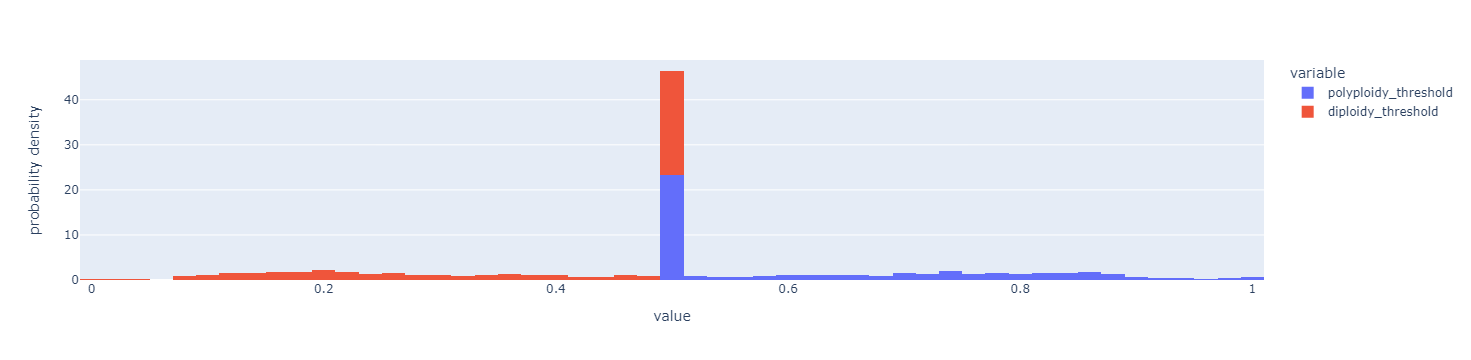

In [31]:
fig = px.histogram(exec_stats, x=["polyploidy_threshold", "diploidy_threshold"], nbins=60, histnorm='probability density')
fig.show()

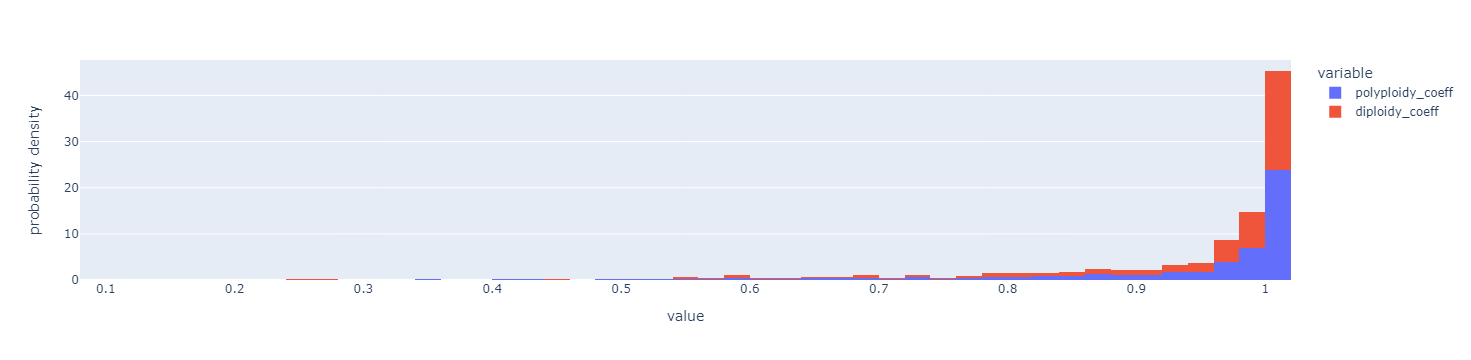

In [32]:
fig = px.histogram(exec_stats, x=["polyploidy_coeff", "diploidy_coeff"], nbins=60, histnorm='probability density')
fig.show()

In [33]:
print(f"# groups where the polyploidy threshold is equal to the disploidy threshold = {exec_stats.loc[exec_stats.diploidy_threshold == exec_stats.polyploidy_threshold].shape[0]:,}")

# groups where the polyploidy threshold is equal to the disploidy threshold = 287


Text(0, 0.5, 'duration(minutes)')

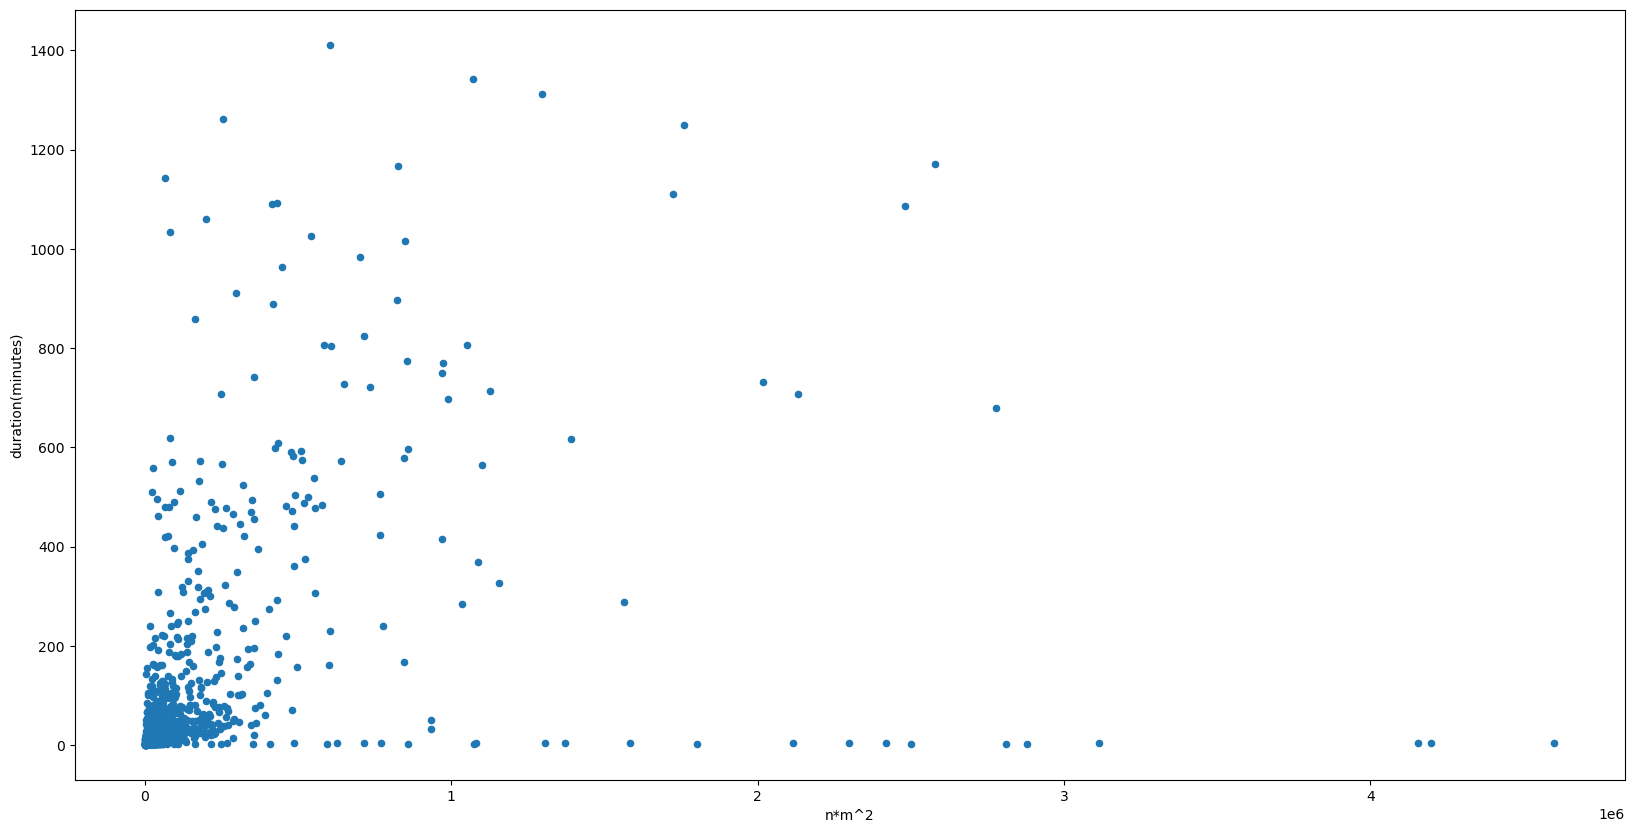

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
exec_stats.loc[exec_stats.outcome == "success"].plot.scatter(x="presumed_running_time", y="duration(minutes)", ax=ax)
ax.set_xlabel("n*m^2")
ax.set_ylabel("duration(minutes)")